In [6]:
import pandas as pd
import numpy as np

In [7]:
data = pd.read_csv('advertising.csv')

In [8]:
data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [9]:
data['Ad Topic Line'].nunique()

1000

In [10]:
data['City'].nunique()

969

In [11]:
data['Country'].nunique()

237

In [12]:
len(data)

1000

In [13]:
data['Clicked on Ad'].mean()

0.5

In [14]:
data['Male'].unique()

array([0, 1])

In [15]:
import datetime

In [16]:
#pd.to_datetime(data['Timestamp']).apply(lambda x: x.day)

In [17]:
data.columns

Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country',
       'Timestamp', 'Clicked on Ad'],
      dtype='object')

In [18]:
data.dtypes

Daily Time Spent on Site    float64
Age                           int64
Area Income                 float64
Daily Internet Usage        float64
Ad Topic Line                object
City                         object
Male                          int64
Country                      object
Timestamp                    object
Clicked on Ad                 int64
dtype: object

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(
    data[['Daily Time Spent on Site', 'Age', 
         'Area Income', 'Daily Internet Usage', 'Male']]
)

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, data['Clicked on Ad'], test_size=0.33, random_state=42
)

In [28]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
#import tensorflow.compat.v2 as tf
tfd = tfp.distributions
%matplotlib inline

In [29]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [30]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
    tfp.layers.VariableLayer(n, dtype=dtype),
    tfp.layers.DistributionLambda(lambda t: tfd.Independent(
        tfd.Normal(loc=t, scale=1),
        reinterpreted_batch_ndims=1)),
    ])

In [32]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
    tfp.layers.VariableLayer(2 * n, dtype=dtype),
    tfp.layers.DistributionLambda(lambda t: tfd.Independent(
        tfd.Normal(
            loc=t[..., :n],
            scale=1e-5 + tf.nn.softplus(c + t[..., n:])
        ),
    reinterpreted_batch_ndims=1)),
    ])

In [220]:
model = tf.keras.Sequential([
    #tfp.layers.DenseVariational(10, posterior_mean_field, prior_trainable, kl_weight=1/X.shape[0], activation='relu'),
    tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/X.shape[0]),
    tfp.layers.DistributionLambda(
        #lambda t: tfd.Normal(
        #    loc=t[..., :1],
        #    scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
        #)
        lambda t: tfd.Bernoulli(
          logits=t[..., :1]#, total_count=100
        )
    ),
])

In [221]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss=negloglik
)
model.fit(X_train, y_train, epochs=1000, verbose=False)

In [206]:
preds = model(X_test)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [207]:
preds.mean().numpy()

array([[0.99692994],
       [0.99996054],
       [0.9998487 ],
       [0.99940157],
       [0.01452786],
       [0.6816558 ],
       [0.02285549],
       [0.9999728 ],
       [0.00597924],
       [0.999997  ],
       [0.00348011],
       [0.9998691 ],
       [0.9999946 ],
       [0.01676834],
       [0.9999738 ],
       [0.9999979 ],
       [0.9999995 ],
       [0.9997256 ],
       [0.06978163],
       [0.99999154],
       [0.00380453],
       [0.9980155 ],
       [0.99999696],
       [0.21866459],
       [0.00390309],
       [0.9999984 ],
       [0.03422147],
       [0.0027318 ],
       [0.9999949 ],
       [0.9998077 ],
       [0.22325158],
       [0.6789272 ],
       [0.00715011],
       [0.9972608 ],
       [0.9999958 ],
       [0.01405767],
       [0.00649586],
       [0.85304224],
       [0.9999597 ],
       [0.9999989 ],
       [0.0305649 ],
       [0.9999927 ],
       [0.80408955],
       [0.9999958 ],
       [0.0127247 ],
       [0.08392632],
       [0.9937537 ],
       [0.999

In [208]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds.mean().numpy())

0.9869194591416813

In [209]:
import scipy
scipy.stats.spearmanr(np.abs(y_test - preds.mean().numpy().squeeze()), preds.variance().numpy().squeeze())

SpearmanrResult(correlation=0.9896811687512208, pvalue=7.656762906321202e-279)

In [210]:
from matplotlib import pyplot as plt
%matplotlib inline

In [211]:
from scipy.stats import norm

def to_classprobs(y_pred):
    class_probs = np.zeros(shape=(y_pred.mean().numpy().shape[0], 2))
    for i, (a, b) in enumerate(zip(y_pred.mean().numpy(), y_pred.variance().numpy())):
        conf = norm.cdf(0.5, a, b)
        class_probs[i, 0] = conf
        class_probs[i, 1] = 1 - conf
    return class_probs

class_probs = to_classprobs(preds)

In [212]:
class_probs.max(axis=1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       0.7987372 , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.95018779, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.94474631, 0.79412649, 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99757024, 1.        , 1.        ,
       1.        , 1.        , 0.97321921, 1.        , 1.        ,
       0.99999997, 1.        , 1.        , 0.58883871, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99999984, 1.     

SpearmanrResult(correlation=0.05440147538164844, pvalue=0.32451026058570176)


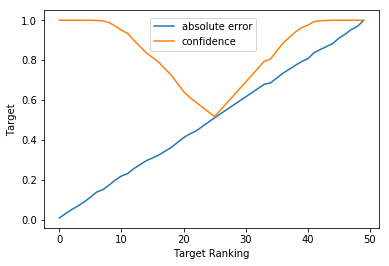

In [213]:
lift_chart(
    preds.mean().numpy().squeeze(),
    class_probs.max(axis=1),
    bins=50, labels=['absolute error', 'confidence']
)

SpearmanrResult(correlation=-0.6272374803782734, pvalue=1.7261367549785668e-37)


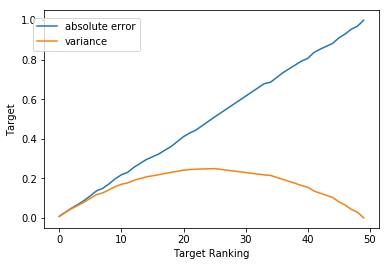

In [217]:
lift_chart(
    preds.mean().numpy().squeeze(),
    preds.variance().numpy().squeeze(),
    bins=50, labels=['absolute error', 'variance']
)

SpearmanrResult(correlation=0.17610495207914012, pvalue=0.0013176573905103975)


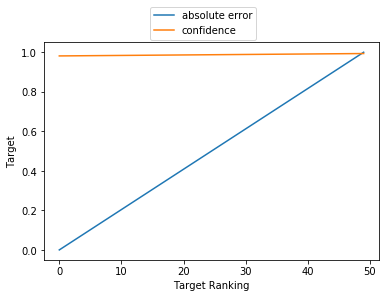

In [214]:
lift_chart(
    y_test,
    class_probs.max(axis=1),
    bins=50, labels=['absolute error', 'confidence']
)

SpearmanrResult(correlation=-0.6050938675817646, pvalue=2.435944282438241e-34)


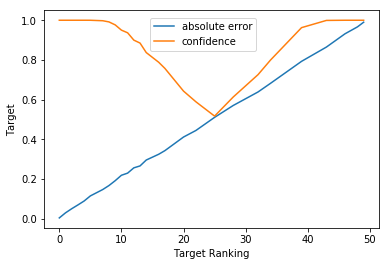

In [215]:
lift_chart(
    np.abs(y_test - preds.mean().numpy().squeeze()),
    class_probs.max(axis=1),
    bins=50, labels=['absolute error', 'confidence']
)

In [170]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy


def lift_chart(y_true, y_pred, bins=10, ax=None, normalize=False, labels=None):
    '''Given matched vectors of true versus predicted
    targets, plot them against each other.
    
    This can be useful for comparing predictions vs targets
    across the whole spectrum. Often a model fits well to
    the mid-range, however, does poorly in the extremes. This
    plot can help spot these problems.
    
    The plot is inspired by Datarobot's lift chart visualization:
    https://twitter.com/hackathorn/status/868136907301146624    
    
    Parameters:
    -----------
    y_true : target values for model
    y_pred : predicted values
    bins : number of bins
    ax : axis, if the lift chart is to be included
      in an existing figure
    normalize : if y_true and y_pred should be (z-)normalized. This
      can be useful to look at variable correlations, where the
      variables can have a different scale.
    labels : the labels to show in the legend/colorbar.
    
    Returns:
    --------
    corr : the Spearman correlation between predicted and actual targets.
    
    Example:
    --------
    >> a = np.random.randn(10000)
    >> lift_chart(a, np.random.randn(10000) * 0.9 + a, bins=100)
    '''    
    if isinstance(y_true, (pd.Series, pd.DataFrame)):
        y_true = y_true.values
    if isinstance(y_pred, (pd.Series, pd.DataFrame)):
        y_pred = y_pred.values

    if normalize:
        y_pred = scipy.stats.zscore(y_pred)
        y_true = scipy.stats.zscore(y_true)
    means, _, _ = scipy.stats.binned_statistic(
        y_true, [y_true, y_pred], bins=bins
    )
    for i, l_mean in enumerate(means):
        if labels is None:
            label='target' if i == 0 else 'pred %d' % i
        else:
            label = labels[i]
        ax = sns.lineplot(
            range(bins), l_mean, label=label,
            ax=ax
        )
    ax.set(xlabel='Target Ranking', ylabel='Target')
    box = ax.get_position()
    ax.legend(
        bbox_to_anchor=(0.3, 0.99),
        ncol=1,     
    )
    print(scipy.stats.spearmanr(y_true, y_pred))
    return ax
